In [ ]:
import pandas as pd

### EDA данных

In [ ]:
%%time
# загружаем данные
source_data = pd.read_csv("hf://datasets/dllllb/age-group-prediction/transactions_train.csv.gz")
df_target = pd.read_csv("hf://datasets/dllllb/age-group-prediction/train_target.csv")

# оставим только 10_000 клиентов
random_client_id = list(set(source_data['client_id'].unique()))[:10_000] # возьмем только 5_000 ID
source_data = source_data[source_data['client_id'].isin(random_client_id)]
df_target = df_target[df_target['client_id'].isin(random_client_id)]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


CPU times: user 10.8 s, sys: 979 ms, total: 11.7 s
Wall time: 18 s


Код по EDA приводите в ячейках ниже:

1) Какое распределение имеет таргет (есть ли дисбаланс даннных)?

In [ ]:
df_target['bins'].value_counts()

,count
bins,
2,2565
3,2538
1,2509
0,2388


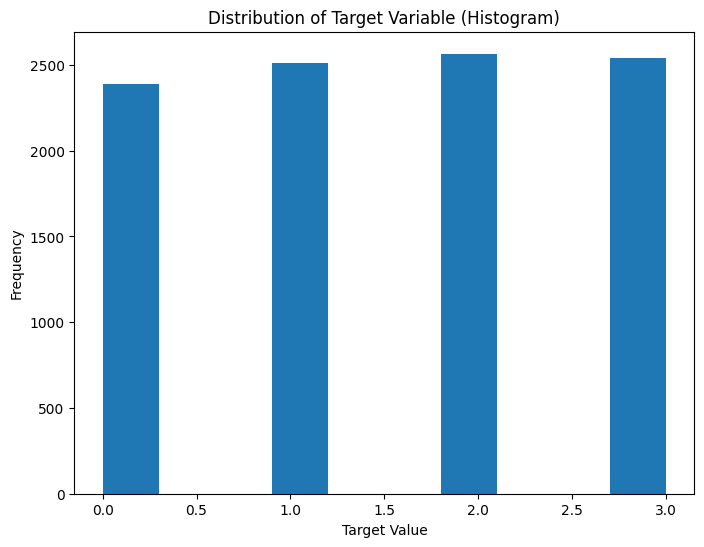

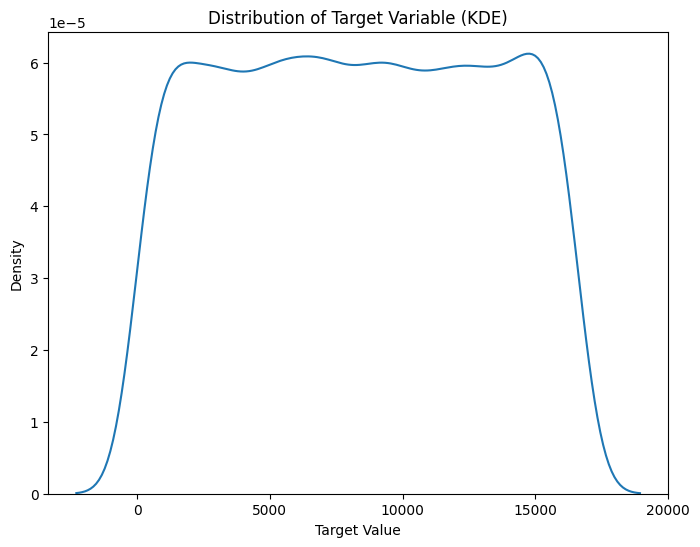

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
plt.hist(df_target['bins'], bins=10)  # Adjust bins as needed
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable (Histogram)')
plt.show()

# 3. KDE plot (сглаженная оценка плотности)
plt.figure(figsize=(8, 6))
sns.kdeplot(df_target['client_id'])
plt.xlabel('Target Value')
plt.ylabel('Density')
plt.title('Distribution of Target Variable (KDE)')
plt.show()

Можно видеть, что небольшой дисбаланас классов наблюдается.

2) Есть ли проблемы с данными по целевой переменной и транзакциям (пропуски/выбросы)?

In [ ]:
source_data.isnull().sum()

,0
client_id,0
trans_date,0
small_group,0
amount_rur,0


In [ ]:
df_target.isnull().sum()

,0
client_id,0
bins,0


Пропусков нет

<Axes: >

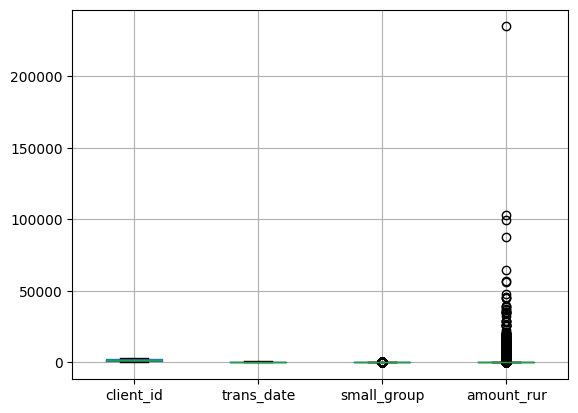

In [ ]:
source_data.boxplot()

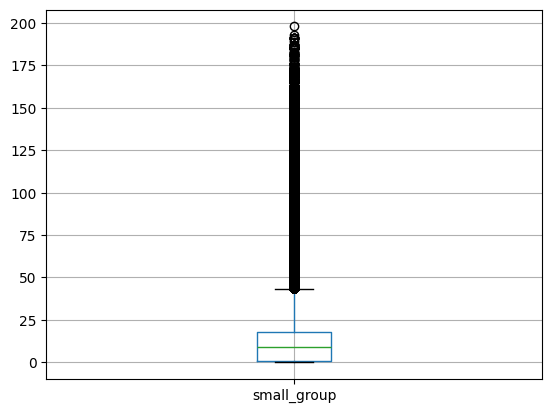

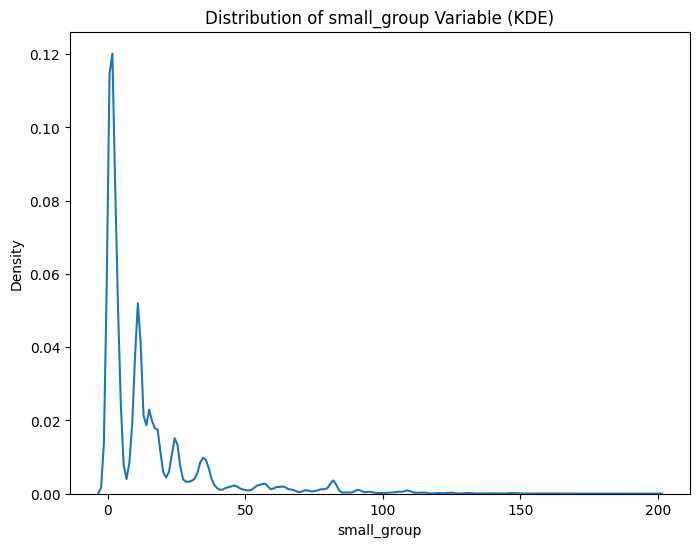

In [ ]:
source_data.boxplot(column=['small_group'])

plt.figure(figsize=(8, 6))
sns.kdeplot(source_data['small_group'])
plt.xlabel('small_group')
plt.ylabel('Density')
plt.title('Distribution of small_group Variable (KDE)')
plt.show()

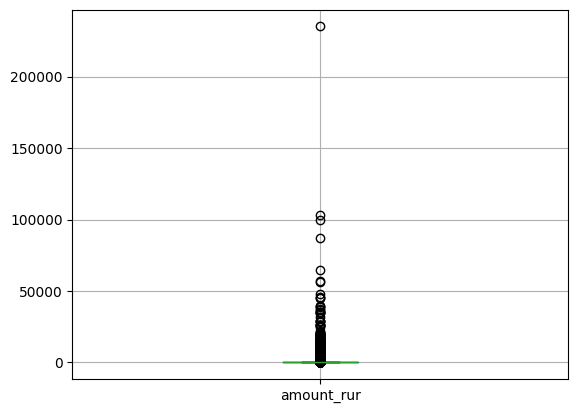

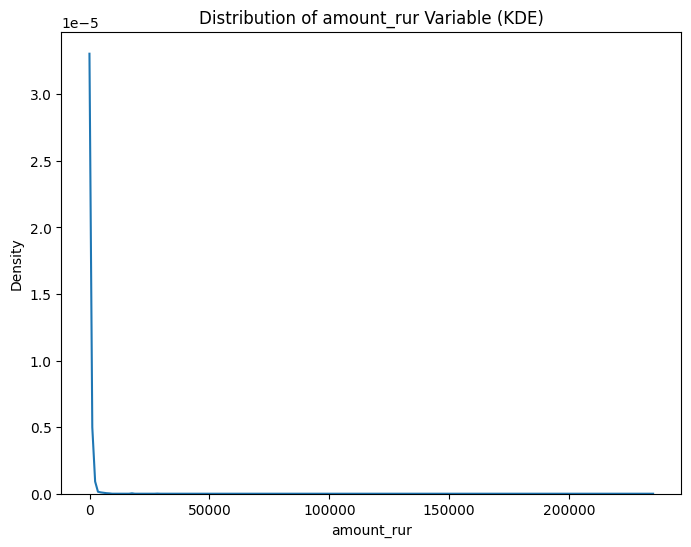

In [ ]:
source_data.boxplot(column=['amount_rur'])

plt.figure(figsize=(8, 6))
sns.kdeplot(source_data['amount_rur'])
plt.xlabel('amount_rur')
plt.ylabel('Density')
plt.title('Distribution of amount_rur Variable (KDE)')
plt.show()

Как можно заметить, в переменных amount_rur и small_group наблюдаются выбросы

3) Нужно ли делать доп. преобразования признаков/таргета для улучшения качества моделирования?

Стоит обрезать выбросы в переменных amount_rur и small_group:

In [ ]:
median_value = source_data['amount_rur'].median()
Q1 = source_data['amount_rur'].quantile(0.05)
Q3 = source_data['amount_rur'].quantile(0.95)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

source_data['amount_rur'] = source_data['amount_rur'].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x) # Замена на медиану вне диапазона

In [ ]:
median_value = source_data['small_group'].median()
Q1 = source_data['small_group'].quantile(0.05)
Q3 = source_data['small_group'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

source_data['small_group'] = source_data['small_group'].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x) # Замена на медиану вне диапазона

### Baseline

1) Разбиваем выборки по client_id.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df = source_data.set_index('client_id').join(df_target.set_index('client_id')).reset_index()

In [ ]:
Y = df['bins']
X = df.drop('bins', axis=1)

In [ ]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42)

2) Генерируем "ручные" признаки на основе транзакций

In [ ]:
def new_feature(df):
  new_df = pd.DataFrame()

  group_counts_dict = df['small_group'].value_counts().to_dict()
  new_df['small_group_counts'] = df['small_group'].map(group_counts_dict)

  new_df['trans_date_max'] = df['trans_date'].max()
  new_df['trans_date_min'] = df['trans_date'].min()
  new_df['trans_date_mean'] = df['trans_date'].mean()
  new_df['trans_date_median'] = df['trans_date'].median()
  new_df['trans_date_std'] = df['trans_date'].std()


  new_df['amount_rur_max'] = df['amount_rur'].max()
  new_df['amount_rur_min'] = df['amount_rur'].min()
  new_df['amount_rur_mean'] = df['amount_rur'].mean()
  new_df['amount_rur_median'] = df['amount_rur'].median()
  new_df['amount_rur_std'] = df['amount_rur'].std()

  return new_df

In [ ]:
trainX_new = new_feature(trainX)
testX_new = new_feature(testX)

3) Обучаем бейзлайн

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(trainX_new, trainY)

pred_lr = lr.predict(testX_new)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

f1_macro = f1_score(testY, pred_lr, average='macro')
print(f"Macro-averaged F1: {f1_macro}")
acc = accuracy_score(testY, pred_lr)
print(f"Accuracy: {acc}")

Macro-averaged F1: 0.1048963177470538
Accuracy: 0.2654906103352865


### Обучение эмбеддингов на транзакциями

In [ ]:
!git clone https://github.com/sberbank-ai-lab/pytorch-lifestream/tree/main/dltranz/data_preprocessing.git

Cloning into 'data_preprocessing'...
fatal: repository 'https://github.com/sberbank-ai-lab/pytorch-lifestream/tree/main/dltranz/data_preprocessing.git/' not found


In [ ]:
!git clone https://github.com/sberbank-ai-lab/pytorch-lifestream.git

fatal: destination path 'pytorch-lifestream' already exists and is not an empty directory.


In [ ]:
!pip install -q torchmetrics==0.11.4
!pip install -q pytorch_lightning==1.9.0

import sys
sys.path.append('/content/pytorch-lifestream')

import torchmetrics
torchmetrics.__version__

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import logging
import pytorch_lightning as pl
import warnings

warnings.filterwarnings('ignore')
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

import os
import pandas as pd
import dltranz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from dltranz.data_preprocessing import PandasDataPreprocessor

# подготавливаем данные для обучения модели
preprocessor = PandasDataPreprocessor(
    col_id='client_id',                         #ID клиента (или геометки)
    cols_event_time='trans_date',               #Временная метка
    time_transformation='float',
    cols_category=["trans_date", "small_group"], #Категории транзакций
    cols_log_norm=["amount_rur"],                #Колонки для нормирования
    cols_identity=[],
    print_dataset_info=False,
)

In [ ]:
from dltranz.seq_encoder import SequenceEncoder
from dltranz.models import Head
from dltranz.lightning_modules.emb_module import EmbModule

seq_encoder = SequenceEncoder(
    category_features=preprocessor.get_category_sizes(), #категории (например, MCC-коды)
    encoder_type='rnn',                                 #тип энкодера
    numeric_features=["amount_rur"],                     #числовые признаки
    trx_embedding_noize=0.003,
)  #формируем энкодер

## "голова" над энкодером: линейный слой + softmax
head = Head(input_size=seq_encoder.embedding_size, use_norm_encoder=True)
model = EmbModule(seq_encoder=seq_encoder, head=head)

In [ ]:
trainX_pr = preprocessor.fit_transform(trainX)
testX_pr = preprocessor.transform(testX)

trainX_pr = sorted(trainX_pr, key=lambda x: x["client_id"])
testX_pr = sorted(testX_pr, key=lambda x: x["client_id"])

In [ ]:
from dltranz.data_load.data_module.emb_data_module import EmbeddingTrainDataModule

dm = EmbeddingTrainDataModule(
    dataset=trainX_pr,
    pl_module=model,
    min_seq_len=5,
    seq_split_strategy='SampleSlices',
    category_names = model.seq_encoder.category_names,
    category_max_size = model.seq_encoder.category_max_size,
    split_count=5,
    split_cnt_min=5,
    split_cnt_max=200,
    train_num_workers=16,
    train_batch_size=100,
    valid_num_workers=16,
    valid_batch_size=100
)

In [ ]:
import torch
import pytorch_lightning as pl

trainer = pl.Trainer(
    max_epochs=20,
    gpus=1,
    enable_checkpointing=False
)

In [ ]:
trainer.fit(model, dm)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

INFO:lightning_fabric.accelerators.cuda:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
from dltranz.inference import get_embeddings

train_embeds = get_embeddings(
    data=trainX_pr,
    model=model,
    category_names = model.seq_encoder.category_names,
    category_max_size = model.seq_encoder.category_max_size,
)

test_embeds = get_embeddings(
    data=testX_pr,
    model=model,
    category_names = model.seq_encoder.category_names,
    category_max_size = model.seq_encoder.category_max_size,
)


2000it [00:00, 98537.64it/s]
2000it [00:00, 104113.19it/s]


In [ ]:
df.rename(columns={"bins": "target"}, inplace=True)

train_df = pd.DataFrame(data=train_embeds,
                        columns=[f'embed_{i}' for i in range(train_embeds.shape[1])]
                        )
train_df['client_id'] = [x['client_id'] for x in trainX_pr]
train_df = train_df.merge(df, how='left', on='client_id')

test_df = pd.DataFrame(data=test_embeds, columns=[f'embed_{i}' for i in range(test_embeds.shape[1])])
test_df['client_id'] = [x['client_id'] for x in testX_pr]
test_df = test_df.merge(df, how='left', on='client_id')

In [ ]:
embed_columns = [x for x in train_df.columns if x.startswith('embed')]
x_train, y_train = train_df[embed_columns], train_df['target'].values
x_test, y_test = test_df[embed_columns], test_df['target'].values

clf = LogisticRegression()
clf.fit(x_train, y_train)

pred_clf = clf.predict(x_test)

In [ ]:
f1_macro_emb = f1_score(y_test, pred_clf, average='macro')
print(f"Macro-averaged F1: {f1_macro_emb}")
acc_emb = accuracy_score(y_test, pred_clf)
print(f"Accuracy: {acc_emb}")

Macro-averaged F1: 0.28717185929208483
Accuracy: 0.35098082640564915


# Обучение на ручных и embedding признаках

In [ ]:
train_c = train_df.join(trainX_new, how='right')
test_c = test_df.join(testX_new, how='right')

In [ ]:
clf = LogisticRegression()
clf.fit(train_c, trainY)

pred_c = clf.predict(test_c)

In [ ]:
f1_macro_c = f1_score(testY, pred_c, average='macro')
print(f"Macro-averaged F1: {f1_macro_c}")
acc_c = accuracy_score(testY, pred_c)
print(f"Accuracy: {acc_c}")

Macro-averaged F1: 0.30923982479344614
Accuracy: 0.4039099294536124


------------------------------

**Выводы:**
1. Проверка на дисбаланс данных: сильного дисбаланаса данных не наблюдается. Поэтому не стоит учитывать веса разных классов в модели
2. Целевая переменная не имеет пропусков как и другие переменные. Выбросы июмет переменные(small_group, amount_rur). Чтобы выбросы не повлияли на предсказание, мы заменим выбросы выше 95% и ниже 5% по нормальному распределению медианой
3. Для модели сформированы ручные признаки: максимальное, минимальное, среднее, медианнное и разброс по trans_date и amount_rur, а также кол-во по каждому small_group
4. Логичтисеская регрессия имеет следующие метрики качества на тесте:
- Macro-averaged F1: 0.1048963177470538
- Accuracy: 0.2654906103352865
5. Были обучены эмбеддинги, которые дали качество на тесте:
- Macro-averaged F1: 0.23106142679979705
- Accuracy: 0.30667102425883647
6. Также были обучены ручные + эмбеддинги признаки, которые дали качество на тесте:
- Macro-averaged F1: 0.309758173987608
- Accuracy: 0.40406002815058584
7. Основными ручными признаками с наибольшей корреляцией c целеовой переменной являются amount_rur_median, amount_rur_std.
Какие гиперпараметры удалось поварьировать для pytorch-lifestream при обучении транзакционных эмбеддингов:
min_seq_len=5, train_batch_size=100,valid_batch_size=100
